In [9]:
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import SGD
import spacy
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score

spacy.require_gpu()
import numpy


In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
processed_directory = '../processed_data/'
train_df = pd.read_json('../processed_data/train.json')
test_df = pd.read_json('../processed_data/test.json')

In [4]:
train_df = train_df.sample(len(train_df), random_state=42)
train_df

,id,text,rating,label
6868,4932,In Panic In The Streets Richard Widmark plays ...,8,+
24016,9115,If you ask me the first one was really better ...,1,-
9668,7452,I am a big fan a Faerie Tale Theatre and I've ...,10,+
13640,11026,I just finished reading a book about Dillinger...,1,-
14018,11367,Greg Davis and Bryan Daly take some crazed sta...,2,-
...,...,...,...,...
21575,6919,My roommates & I nearly shorted out our TV fro...,2,-
5390,3601,Michelle Rodriguez is the defining actress who...,7,+
860,10775,Nice movie with a great soundtrack which spans...,8,+
15795,1716,"Even though this was a made-for-TV production,...",1,-


# Storing some variables

In [5]:
train_len = int(0.8*len(train_df))

In [6]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x2092b3c2ee0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x2092b3c2c40>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x2092b09fc80>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x2092b5e7800>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x2092b603a40>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x2092b09fc10>)]

In [7]:
def one_hot(row):
    if row == '-':
        return [1, 0]
    else:
        return [0, 1]
    
def get_features(df):
    text_list = df['text'].to_list()
    x = []
    for doc in tqdm_notebook(nlp.pipe(text_list, disable=["tagger", "parser", "lemmatizer", 'attribute_ruler', 'ner']),total=len(text_list) ):
        x.append(doc.vector.get())
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [8]:
train_x, train_y = get_features(train_df)
test_x, test_y = get_features(test_df)

  0%|          | 0/25000 [00:00<?, ?it/s]

NameError: name 'np' is not defined

In [11]:
train_x

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.006977,0.152942,-0.131309,-0.036154,0.122642,0.012373,-0.016544,-0.126087,-0.029805,2.124057,...,-0.164012,0.049071,0.032471,-0.056707,0.007302,-0.010890,-0.064989,-0.071053,-0.014184,0.045542
1,0.012072,0.130510,-0.104212,-0.063575,0.084911,-0.025344,-0.035447,-0.114975,-0.006386,1.935403,...,-0.190982,0.006450,0.008672,-0.029648,0.027210,0.010179,0.024023,-0.044958,-0.012830,0.056736
2,-0.097324,0.184632,-0.128490,-0.084664,0.054203,0.032274,0.047223,-0.114767,0.014312,2.152641,...,-0.172063,0.022724,-0.101178,-0.023656,0.044661,0.068299,-0.024370,-0.091496,-0.002683,0.093178
3,-0.027772,0.130567,-0.152985,-0.047217,0.071326,0.016790,-0.003706,-0.101126,-0.009193,2.152511,...,-0.233026,0.042364,-0.024650,-0.034881,0.024407,0.030208,-0.044393,-0.083346,0.033778,0.086929
4,-0.027660,0.171387,-0.097587,-0.055611,0.107496,0.039108,0.027723,-0.104099,-0.018723,2.075550,...,-0.155245,0.034445,-0.011114,-0.040261,0.006755,0.027404,-0.046025,-0.048126,-0.025229,0.035457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-0.030652,0.130034,-0.115811,-0.049625,0.089282,-0.006514,0.038002,-0.112348,-0.015421,2.150479,...,-0.164964,0.049693,0.025036,-0.068340,0.005200,0.045247,-0.028728,0.007879,0.023769,0.092720
24996,-0.030462,0.185232,-0.091917,-0.073782,0.093834,0.055192,0.038778,-0.165647,-0.020743,2.113348,...,-0.188884,0.054723,0.005237,-0.019912,0.050026,-0.051562,-0.068628,-0.098007,-0.023132,0.143531
24997,-0.006854,0.121101,-0.092479,-0.042141,0.070015,-0.053947,0.029291,-0.094470,0.001424,1.957572,...,-0.149024,0.020803,0.017507,-0.023384,-0.011275,0.019338,-0.048050,-0.083139,-0.070448,0.045597
24998,0.011233,0.128624,-0.120690,-0.084393,0.079866,0.054415,0.022280,-0.146740,0.024745,2.133624,...,-0.178119,0.093841,-0.012928,-0.043249,0.075504,-0.001530,-0.012723,-0.033844,-0.008538,0.097597


In [12]:
train_y

,+,-
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
24995,0,1
24996,1,0
24997,1,0
24998,1,0


In [19]:
model = Sequential([
    Dense(512, input_shape=(300,), activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_ffnn/checkpoint',
                   save_best_only=True, verbose=1,monitor='val_accuracy')
]

In [20]:
# model.compile(optimizer=SGD(momentum=0.02), loss=BinaryCrossentropy(), metrics='accuracy')
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_split=0.3,
         callbacks=callbacks)

Epoch 1/50
541/547 [============================>.] - ETA: 0s - loss: 0.4430 - accuracy: 0.7914
Epoch 1: val_accuracy improved from -inf to 0.83173, saving model to ./models\checkpoint
INFO:tensorflow:Assets written to: ./models\checkpoint\assets
547/547 [==============================] - 4s 6ms/step - loss: 0.4430 - accuracy: 0.7917 - val_loss: 0.4070 - val_accuracy: 0.8317
Epoch 2/50
544/547 [============================>.] - ETA: 0s - loss: 0.3852 - accuracy: 0.8320
Epoch 2: val_accuracy improved from 0.83173 to 0.85173, saving model to ./models\checkpoint
INFO:tensorflow:Assets written to: ./models\checkpoint\assets
547/547 [==============================] - 3s 6ms/step - loss: 0.3850 - accuracy: 0.8320 - val_loss: 0.3523 - val_accuracy: 0.8517
Epoch 3/50
533/547 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8398
Epoch 3: val_accuracy improved from 0.85173 to 0.85187, saving model to ./models\checkpoint
INFO:tensorflow:Assets written to: ./models\checkpoin

In [67]:
model = load_model('./models/checkpoint')

In [68]:
def change_value(row):
    if (row == 0):
        return '+'
    elif (row == 1) :
        return '-'

def remap(y):
    res= y.argmax(axis=1)
    df = pd.DataFrame(res, columns=['Predicted'])
    df['Predicted'] = df['Predicted'].apply(change_value)
    return df

def predict_result(model, x):    
    y_pred = model.predict(x)
    return remap(y_pred)
    

In [69]:
y_pred = predict_result(model, train_x)
y_true = remap(train_y.to_numpy())

In [70]:
print(f"acc: {accuracy_score(y_pred,y_true)}")
print(f"f1: {f1_score(y_pred,y_true, average='micro')}")              

acc: 0.87508
f1: 0.8750799999999999


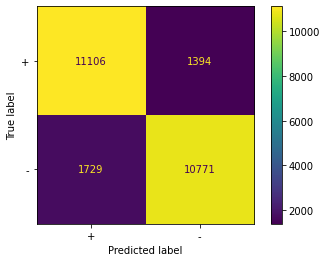

In [71]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [72]:
y_pred = predict_result(model, test_x)
y_true = remap(test_y.to_numpy())

In [73]:
print(f"acc: {accuracy_score(y_pred,y_true)}")
print(f"f1: {f1_score(y_pred,y_true, average='micro')}")              

acc: 0.85748
f1: 0.85748


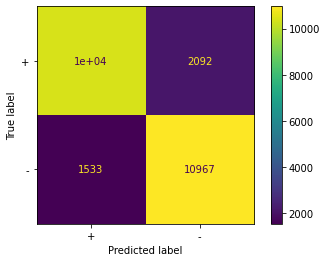

In [33]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [38]:
train_x.to_csv('./train_x.csv', index=False)
train_y.to_csv('./train_y.csv', index=False)
test_x.to_csv('./test_x.csv', index=False)
test_y.to_csv('./test_y.csv', index=False)